# Controller Parameter Bounds

The goal of this notebook is to visualize the effect of change in controller params(kp, ki, and alpha) on the system's response to prolonged market deviations(step inputs). This will guide the decisioning on how to bound the controller parameters after ungoverning.

For a review of ki, and alpha parameters and factors when setting the, review this community forum discussion. https://community.reflexer.finance/t/rai-controller-ungovernance/208/7

The lengthy post can also be found as a hackmd doc.
https://hackmd.io/s2uQpHwUS96k3Ox72sybPw

In [1]:
import time
import math
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

# Review of RAI redemption price rate calculatiom

$rate_{t} = K_p * error_{t} + K_i * error\_sum_{t}$

where:

$error_{t} = target\_price_{t} - market\_price_{t}$ 

and $error\_sum$ is the time-decayed sum of previous errors:

$error\_sum_{t} = error\_sum_{t-1} * {alpha}^{timel\_delta} + (error_{t-1} + error_{t}))/2 * time\_delta$

As the following visualization shows, the error sum(also called error integral), is equal to the time decayed value of the existing error sum plus the new time weighted error.

## Error Sum Calculation Example

![](./leaky_integral.png)

From the above visualization, you can see that each new error area will be decayed more the older it gets. The new error becomes part of the integral and will thus be decayed each time a new error is added.

___

#  Find closed-form equation for error integral

For a step input with constant error(constant market deviation), we can create a closed-form solution for the integral after a specific time period using the geometric series.  

Let:

### $error$ be the fixed step error in $USD

### $alpha$ be the chosen value used for integral decay

### $time\_delta$ be the constant time between error updates

Then,  


### $alpha^{time\_delta} = d$ is a constant

and

### $error \cdot time\_delta = c$ is a constant


So the recursive error integral equation becomes.

### $error\_integral_{n+1} = error\_integral_{n} \cdot d + c \ \ \ \ \ \ \ \ \ (1)$



Equation (1) is the geometric series:
    
### $error\_integral_{n} =  c  \sum \limits _{n=0} ^{n-1} d^{i}$


    

We can use the geometric series identity to find the error integral for any $n$




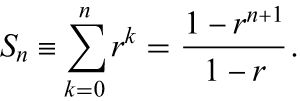

source: https://mathworld.wolfram.com/GeometricSeries.html



### Thus,

### $error\_integral_{n} =  c  \sum \limits _{n=0} ^{n-1} d^{i}$

### $error\_integral_{n} = c \frac{1 - d^{n}}{1-d}$
### $error\_integral_{n} = c \frac{1 - {alpha^{time\_delta}}^{n}}{1-d}$ 

### $error\_integral_{n} = c \frac{1 - alpha^{n*time\_delta}}{1-alpha^{time\_delta}}$

### $error\_integral_{n} = error \cdot time\_delta \frac{1 - alpha^{n*time\_delta}}{1-alpha^{time\_delta}} \ \ \ \ \ \ \ \ \ (2)$

### Use Equation (2) to find the integral rate after a certain time length of a fixed step(market deviation)

In [2]:
def to_apy(per_sec_rate):
    # Convert per-second rate to annual rate
    return float(((1 + Decimal(per_sec_rate)) ** Decimal(86400*365) - 1) * 100)   

In [3]:
# Equation (2)
def step_integral_rate(error, n_periods, alpha, time_delta, ki):
    # return per-second rate for fixed error after n_periods
    error_sum = Decimal((error * time_delta)) * (1 - Decimal(alpha)**Decimal(n_periods * time_delta))/(1-Decimal(alpha)**Decimal(time_delta))
    
    return float(error_sum) * ki

# total rate: integral rate plus proportional rate
def step_rate(error, n_periods, alpha, time_delta, ki, kp):
    integral_rate = step_integral_rate(error, n_periods, alpha, time_delta, ki)
    p_rate = float(Decimal(error) * Decimal(kp))
    
    return p_rate + integral_rate

In [4]:
r = step_integral_rate(-0.15, 60, 0.999999, 86400, 2.23e-14)
to_apy(r)

-9.68499544456725

In [ ]:
upper hits current max rr(-87%) after 60d of $0.15 deviation w/ 1 year leak

In [18]:
r = to_apy(step_integral_rate(-0.15, 60, calc_alpha(365), 86400, 1.0e-13))
r

-85.69293686436116

## Finding the limit of the error integral and thus the max integral rate

We can also use the limit of the geomtric series to find the maxium value the integral sum can attain

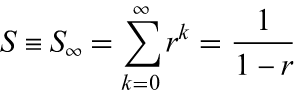

source: https://mathworld.wolfram.com/GeometricSeries.html



The above yields:

# $\lim_{n\to\infty} error\_integral_{n} = c \sum \limits _{n=0} ^{\infty} d^i$

# $\lim_{n\to\infty} error\_integral_{n} = c \frac{1}{1-d} = \frac{c}{1-d}$

# $\lim_{n\to\infty} error\_integral_{n} =  \frac{error \cdot time\_delta}{1-alpha^{time\_delta}} \ \ \ \ \ \ \ \ \ (3)$

### Use Equation (3) to find the max integral rate of a fixed step(market deviation)

In [5]:
# Using Equation 3
def max_integral_rate(error, alpha, time_delta, ki):
    max_error_sum = Decimal(error * time_delta)/ Decimal((1-alpha**time_delta))
    return float(max_error_sum * Decimal(ki))

# total rate: integral rate plus proportional rate
def max_rate(error, alpha, time_delta, ki, kp):
    max_i_rate = max_integral_rate(error, alpha, time_delta, ki)
    p_rate = float(Decimal(error) * Decimal(kp))
    
    return p_rate + max_i_rate

In [6]:
per_sec = max_integral_rate(-0.15, 0.999999, 86400, 2.23e-14)
per_sec

-3.4915829271976615e-09

In [7]:
max_apy = to_apy(per_sec)
max_apy

-10.426490209907925

## Visualization
Use closed-form equations for integral rates/maxes to visualize ki/alpha affects

#### Create some alpha and ki values 

In [8]:
def calc_alpha(n_days):
    # calculate 'n-day' alpha value
    # return alpha st. 95% of the integrals is composed of most recent `n_days` days
    base = Decimal(1 - 0.95)
    
    return float(base**(1/Decimal(86400*n_days)))

In [9]:
#alpha_days = range(0, 390, 30)[1:]
n_days = 50
alpha_days = np.round(np.linspace(30, 720, n_days), 0)
alphas = [calc_alpha(d) for d in alpha_days]
print(alpha_days)

[ 30.  44.  58.  72.  86. 100. 114. 129. 143. 157. 171. 185. 199. 213.
 227. 241. 255. 269. 283. 298. 312. 326. 340. 354. 368. 382. 396. 410.
 424. 438. 452. 467. 481. 495. 509. 523. 537. 551. 565. 579. 593. 607.
 621. 636. 650. 664. 678. 692. 706. 720.]


In [10]:
n_ki = 50
min_ki = 1e-14
max_ki = 1e-13
kis = np.round(np.linspace(min_ki, max_ki, n_ki), 15)
print(kis)

[1.0e-14 1.2e-14 1.4e-14 1.6e-14 1.7e-14 1.9e-14 2.1e-14 2.3e-14 2.5e-14
 2.7e-14 2.8e-14 3.0e-14 3.2e-14 3.4e-14 3.6e-14 3.8e-14 3.9e-14 4.1e-14
 4.3e-14 4.5e-14 4.7e-14 4.9e-14 5.0e-14 5.2e-14 5.4e-14 5.6e-14 5.8e-14
 6.0e-14 6.1e-14 6.3e-14 6.5e-14 6.7e-14 6.9e-14 7.1e-14 7.2e-14 7.4e-14
 7.6e-14 7.8e-14 8.0e-14 8.2e-14 8.3e-14 8.5e-14 8.7e-14 8.9e-14 9.1e-14
 9.3e-14 9.4e-14 9.6e-14 9.8e-14 1.0e-13]


In [11]:
to_apy(step_integral_rate(-0.15, calc_alpha(120), 86400, 90, 2.23e-14))

-0.0009491061889564688

In [12]:
prod_kp = 7.5e-8
prod_ki = 2.23E-14
prod_alpha_days = 120

## Step Integral Rate Heatmap

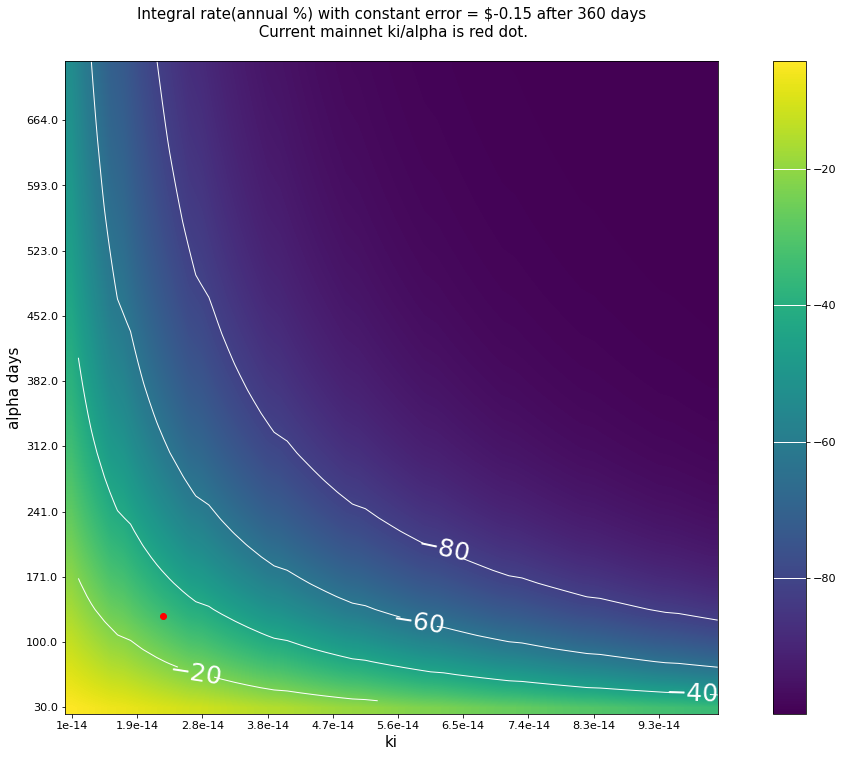

In [14]:
error = -0.15
time_delta = 86400

step_days = 360
z = np.array([to_apy(step_integral_rate(error, step_days, alpha, time_delta, ki)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))
# clip large rates
#Z = np.clip(Z, -60, 0)

fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')

contour = plt.contour(Z, [-80,-60,-40,-20], origin='lower', colors=['white'],
                      linestyles='solid', linewidths=1)
ax.clabel(contour, inline=True, fontsize=25, colors='white')

# plot value closest to current Ki, alpha
ax.scatter(np.searchsorted(kis, prod_ki), np.searchsorted(alphas, calc_alpha(prod_alpha_days)), color='red')

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])
ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Integral rate(annual %) with constant error = ${error} after {step_days} days\n Current mainnet ki/alpha is red dot.')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
cbar = fig.colorbar(im)
cbar.add_lines(contour)
cbar.set_ticks([-80, -60, -40, -20])
plt.show()

## Step Total Rate Heatmap

In [ ]:
error = -0.15
time_delta = 86400
kp = prod_kp
step_days = 360
z = np.array([to_apy(step_rate(error, step_days, alpha, time_delta, ki, kp)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
#Z = np.clip(Z, -87.5, 0)

fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')
contour = plt.contour(Z, [-80,-60,-40,-20], origin='lower', colors=['white'],
                      linestyles='solid', linewidths=1)
ax.clabel(contour, inline=True, fontsize=25, colors='white')

# plot closest value to current Ki, alpha
ax.scatter(np.searchsorted(kis, prod_ki), np.searchsorted(alphas, calc_alpha(prod_alpha_days)), color='red')

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])
ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Total rate(annual %) with constant error = ${error} after {step_days} days, {kp=}')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
cbar = fig.colorbar(im)
cbar.add_lines(contour)
cbar.set_ticks([-80, -60, -40, -20])
plt.show()

## Max Integral Rate Heatmap

In [ ]:
error = -0.15
time_delta = 86400

z = np.array([to_apy(max_integral_rate(error, alpha, time_delta, ki)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
#Z = np.clip(Z, -60, 0)

fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')
contour = plt.contour(Z, [-80,-60,-40,-20], origin='lower', colors=['white'],
                      linestyles='solid', linewidths=1)
ax.clabel(contour, inline=True, fontsize=25, colors='white')

# plot closest value to current Ki, alpha
ax.scatter(np.searchsorted(kis, prod_ki), np.searchsorted(alphas, calc_alpha(prod_alpha_days)), color='red')

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])
ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Max possible integral rate(annual %) with constant error = ${error}')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
fig.colorbar(im)
cbar.add_lines(contour)
cbar.set_ticks([-80, -60, -40, -20])
plt.show()

## Max Total Rate Heatmap

In [ ]:
error = -0.15
time_delta = 86400
kp=7.5e-8

z = np.array([to_apy(max_rate(error, alpha, time_delta, ki, kp)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
#Z = np.clip(Z, -60, 0)

fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')
contour = plt.contour(Z, [-80,-60,-40,-20], origin='lower', colors=['white'],
                      linestyles='solid', linewidths=1)
ax.clabel(contour, inline=True, fontsize=25, colors='white')

# plot closest value to current Ki, alpha
ax.scatter(np.searchsorted(kis, prod_ki), np.searchsorted(alphas, calc_alpha(prod_alpha_days)), color='red')

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])
ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Max possible total rate(annual %) with constant error = ${error}, {kp=}')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
fig.colorbar(im)
cbar.add_lines(contour)
cbar.set_ticks([-80, -60, -40, -20])
plt.show()

In [ ]:
to_apy(max_integral_rate(0.15, 0.9999999050059570000, 86400, 4.2e-14))

In [ ]:
to_apy(step_integral_rate(-0.15, 60, 0.9999999050059570000, 86400, 1e-13))

In [ ]:
to_apy(max_rate(error=-0.15, alpha=0.9999999050059570000, time_delta=86400, ki=3.5e-14, kp=7.5e-8))

In [ ]:
to_apy(step_rate(error=-0.15, n_periods=90, alpha=0.9999999050059570000, time_delta=86400, ki=6.5e-14, kp=7.5e-8))

In [ ]:
import itertools

n_kp = 10
kps = np.round(np.linspace(1e-8, 4e-7, n_kp), 9)

n_ki = 10
kis = np.round(np.linspace(1e-14, 8e-14, n_ki), 15)

n_days = 10
alpha_days = np.round(np.linspace(30, 720, n_days), 0)
alphas = [calc_alpha(d) for d in alpha_days]


l = [kps, kis, alphas]
all_params = list(itertools.product(*l))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

z = np.array([to_apy(max_rate(error, alpha, time_delta, ki, kp)) for kp, ki, alpha in all_params])

expanded_kps = [p[0] for p in all_params]
expanded_kis = [p[1] for p in all_params]
expanded_alphas = [p[2] for p in all_params]


c = np.abs(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmhot = plt.get_cmap("hot")
cax = ax.scatter(expanded_kps, expanded_kis, expanded_alphas, z, s=5, alpha=0.2, c=c, cmap=cmhot)

plt.show()